# Problem 2

In [1]:
import load_helper

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import importlib

from torch import tensor

In [14]:
fname = '2.daphne'
graph = load_helper.graph_helper(fname)
%cat 2.daphne

(defn observe-data [_ data slope bias]
  (let [xn (first data)
        yn (second data)
        zn (+ (* slope xn) bias)]
    (observe (normal zn 1.0) yn)
    (rest (rest data))))

(let [slope (sample (normal 0.0 10.0))
      bias  (sample (normal 0.0 10.0))
      data (vector 1.0 2.1 2.0 3.9 3.0 5.3
                   4.0 7.7 5.0 10.2 6.0 12.9)]
  (loop 6 data observe-data slope bias)
  (vector slope bias))

In [3]:
import bbvi
importlib.reload(bbvi)

from bbvi import graph_bbvi_algo12

In [4]:
%%time
T=10000
L=10
lr=0.05
r, logW, sigma = bbvi.graph_bbvi_algo12(graph,T=T,L=L,lr=lr,
                                   do_log=False)

t=0, Q after step={'sample1': Normal(loc: 0.04999999701976776, scale: 9.999954223632812), 'sample2': Normal(loc: 0.04999999701976776, scale: 9.999954223632812)}
t=1000, Q after step={'sample1': Normal(loc: 1.966282606124878, scale: 0.35881099104881287), 'sample2': Normal(loc: -0.07611042261123657, scale: 2.1672756671905518)}
t=2000, Q after step={'sample1': Normal(loc: 2.102851629257202, scale: 0.18338362872600555), 'sample2': Normal(loc: -0.42446640133857727, scale: 0.6566195487976074)}
t=3000, Q after step={'sample1': Normal(loc: 2.1381676197052, scale: 0.12904785573482513), 'sample2': Normal(loc: -0.4206306040287018, scale: 0.45331424474716187)}
t=4000, Q after step={'sample1': Normal(loc: 2.13557505607605, scale: 0.11017777770757675), 'sample2': Normal(loc: -0.5013607144355774, scale: 0.4187203347682953)}
t=5000, Q after step={'sample1': Normal(loc: 2.1337504386901855, scale: 0.10388973355293274), 'sample2': Normal(loc: -0.506049394607544, scale: 0.4013504683971405)}
t=6000, Q afte

Text(0.5, 1.0, '2.daphne  \n Best ELBO -12.32 \n T=10000 | L=10 | Adam, lr=0.05 ')

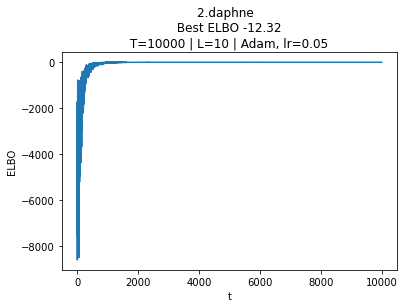

In [5]:
elbo = logW.mean(1)
pd.Series(elbo).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

Text(0.5, 1.0, '2.daphne  \n Best ELBO -12.32 \n T=10000 | L=10 | Adam, lr=0.05 ')

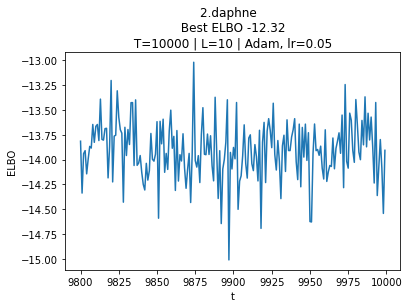

In [6]:
sr = pd.Series(elbo[-200:])
sr.index = np.arange(elbo.size-200,elbo.size)
sr.plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

In [7]:
r_array = np.zeros((T,L,2))
for t in range(T):
    for l in range(L):
        r_array[t,l,:] = r[t][l].detach().numpy()

In [8]:

probs = np.exp(logW)
probs /= probs.sum()
probs = probs.reshape(T,L,1)
posterior_r = (probs * r_array).sum(axis=(0,1))
posterior_r2 = (probs * r_array**2).sum(axis=(0,1))

std_r = np.sqrt(posterior_r2 - posterior_r**2)


In [9]:
idx=0
print('{} expected posterior slope {:1.3f} | std posterior slope {:1.3f}'.format(fname,posterior_r[idx],std_r[idx]))
idx=1
print('{} expected posterior bias {:1.3f} | std posterior bias {:1.3f}'.format(fname,posterior_r[idx],std_r[idx]))


2.daphne expected posterior slope 2.154 | std posterior slope 0.206
2.daphne expected posterior bias -0.530 | std posterior bias 0.800


Text(0.5, 1.0, '2.daphne  \n Trace \n T=10000 | L=10 | Adam, lr=0.05 ')

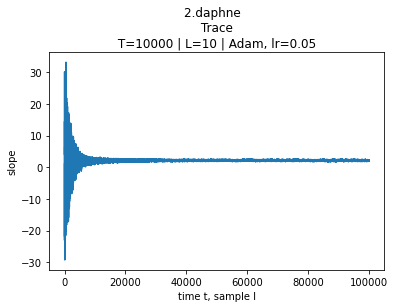

In [10]:
trace = r_array[:,:,0].flatten()
pd.Series(trace).plot()
plt.xlabel('time t, sample l')
plt.ylabel('slope')
plt.title('{}  \n Trace \n T={} | L={} | Adam, lr={} '.format(fname,T,L,lr))

Text(0.5, 1.0, '2.daphne  \n Trace \n T=10000 | L=10 | Adam, lr=0.05 ')

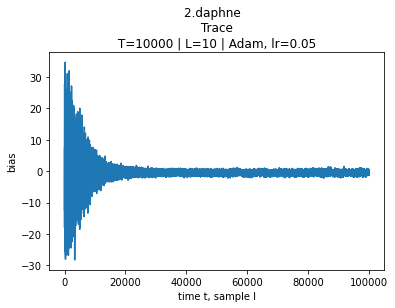

In [11]:
trace = r_array[:,:,1].flatten()
pd.Series(trace).plot()
plt.xlabel('time t, sample l')
plt.ylabel('bias')
plt.title('{}  \n Trace \n T={} | L={} | Adam, lr={} '.format(fname,T,L,lr))

Text(0.5, 1.0, '2.daphne \n posterior of slope (learned proposal) \nslope $\\sim \\mathcal{N}$$[loc=2.127, scale=0.102]$')

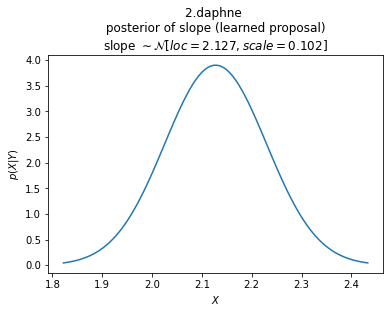

In [12]:
Q = sigma['Q_best_t']
q = Q['sample1']
loc = q.loc.detach().numpy()
scale = q.scale.detach().numpy()
support = np.linspace(loc-3*scale,loc+3*scale,100)
log_pdf = np.zeros_like(support)
for idx,c in enumerate(support):
    log_pdf[idx] = q.log_prob(tensor(c))
pdf = np.exp(log_pdf)

sr = pd.Series(pdf)
sr.index = support
sr.plot()
plt.xlabel('$X$')
plt.ylabel('$p(X|Y)$')
plt.title(\
          '{} \n posterior of slope (learned proposal) \n'.format(fname) +\
          'slope $\sim \mathcal{N}$' +\
          '$[loc={:1.3f}, scale={:1.3f}]$'.format(loc,scale)
         )

Text(0.5, 1.0, '2.daphne \n posterior of bias (learned proposal) \nbias $\\sim \\mathcal{N}$$[loc=-0.504, scale=0.463]$')

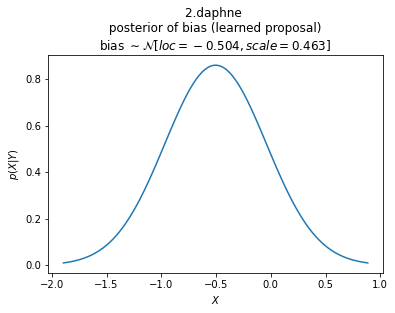

In [13]:
Q = sigma['Q_best_t']
q = Q['sample2']
loc = q.loc.detach().numpy()
scale = q.scale.detach().numpy()
support = np.linspace(loc-3*scale,loc+3*scale,100)
log_pdf = np.zeros_like(support)
for idx,c in enumerate(support):
    log_pdf[idx] = q.log_prob(tensor(c))
pdf = np.exp(log_pdf)

sr = pd.Series(pdf)
sr.index = support
sr.plot()
plt.xlabel('$X$')
plt.ylabel('$p(X|Y)$')
plt.title(\
          '{} \n posterior of bias (learned proposal) \n'.format(fname) +\
          'bias $\sim \mathcal{N}$' +\
          '$[loc={:1.3f}, scale={:1.3f}]$'.format(loc,scale)
         )